In [1]:
%cd ..

%load_ext line_profiler
from IPython.core.debugger import set_trace

/home/proste/mff/evgena


In [2]:
from genetals.core import *
from genetals.callbacks import GAStatus, MultiObjectiveReport
from genetals.operators import TwoPointXover, BiasedMutation, ShuffleOperator, NSGAOperator
from genetals.initializers import RandomStdInit
from evgena.datasets import load_emnist, load_mnist, load_nprecord
from evgena.models import Model, TfModel
# from evgena.metrics import SSIM
from evgena.utils.large_files import maybe_download

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/home/proste/mff/evgena/env_evgena/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class SSIM:
    def __init__(self, size=11, sigma=1.5, K1=0.01, K2=0.03, seed=42):
        graph = tf.Graph()
        graph.seed = seed
        self.session = tf.Session(graph=graph)
        
        with graph.as_default():
            # input placeholders
            self.images_x = tf.placeholder(tf.float32, [None, None, None, 1], name='images_x')  # TODO shapes??
            self.images_y = tf.placeholder(tf.float32, [None, None, None, 1], name='images_y')
            
            # weighting gaussian window
            window_half = size // 2
            x_data, y_data = np.mgrid[-window_half:window_half+1,-window_half:window_half+1]

            g = np.exp(-((x_data**2 + y_data**2)/(2.0*sigma**2)))
            normed_g = g / np.sum(g)
            normed_g = normed_g.reshape(normed_g.shape + (1, 1))
            
            window = tf.constant(normed_g, dtype=tf.float32)
            
            C1 = tf.constant(K1**2, dtype=tf.float32)
            C2 = tf.constant(K2**2, dtype=tf.float32)
            C3 = tf.constant((K2**2) / 2, dtype=tf.float32)
            
            # ssim computation
            mu_x = tf.nn.conv2d(self.images_x, window, strides=[1, 1, 1, 1], padding='VALID')
            mu_x_sq = mu_x * mu_x
            sigma_x_sq = tf.abs(tf.nn.conv2d(self.images_x*self.images_x, window, strides=[1, 1, 1, 1], padding='VALID') - mu_x_sq)
            sigma_x = tf.sqrt(sigma_x_sq)
            
            mu_y = tf.nn.conv2d(self.images_y, window, strides=[1, 1, 1, 1], padding='VALID')
            mu_y_sq = mu_y * mu_y
            sigma_y_sq = tf.abs(tf.nn.conv2d(self.images_y*self.images_y, window, strides=[1, 1, 1, 1], padding='VALID') - mu_y_sq)
            sigma_y = tf.sqrt(sigma_y_sq)
            
            mu_xy = mu_x * mu_y
            sigma_xy = tf.abs(tf.nn.conv2d(self.images_x*self.images_y, window, strides=[1, 1, 1, 1], padding='VALID') - mu_xy)
            
            self.ssim_luminance = (2 * mu_xy + C1) / (mu_x_sq + mu_y_sq + C1)
            self.ssim_contrast = (2 * sigma_x * sigma_y + C2) / (sigma_x_sq + sigma_y_sq + C2)
            self.ssim_structure = (sigma_xy + C3) / (sigma_x * sigma_y + C3)
            self.ssim_map = self.ssim_luminance * self.ssim_contrast * self.ssim_structure
            self.ssim_metrics = tf.reduce_mean(self.ssim_map, axis=[1, 2, 3])

    def __call__(self, images_x, images_y):
        if images_y.shape != images_x.shape:
            raise ValueError('images_x and images_y shapes mismatch - shapes must be equal')
            
        if len(images_x.shape[1:]) == 2:
            images_x = np.expand_dims(images_x, -1)
            images_y = np.expand_dims(images_y, -1)
        
        return self.session.run(
            self.ssim_metrics,
            feed_dict={self.images_x: images_x, self.images_y: images_y}
        )

In [4]:
class BestImgReport(CallbackBase):
    def __init__(self, ax: plt.Axes = None, best_picker = None):
        super(BestImgReport, self).__init__()
        
        if ax is None:
            self._fig, self._ax = plt.subplots(1, 1)
        else:
            self._fig, self._ax = ax.figure, ax
        
        self._best_picker = (lambda fitness: fitness.argmax()) if (best_picker is None) else best_picker
        
    def __call__(self, ga: GeneticAlgorithm) -> None:
        offspring = ga.capture(-1)
        best_i = self._best_picker(offspring.fitnesses)
        
        self._ax.imshow(offspring.individuals[best_i], cmap='plasma', vmin=-1, vmax=1)

In [5]:
class MultiSigmaRandomInit(InitializerBase):
    def __init__(self, individual_shape, sigmas = (1,), mu: np.ndarray = 0):
        super(MultiSigmaRandomInit, self).__init__()

        self._individual_shape = individual_shape
        self._sigmas = sigmas
        self._mu = mu

    def __call__(self, population_size: int, *args, **kwargs) -> np.ndarray:
        sigmas = np.tile(self._sigmas, (population_size + (len(self._sigmas) - 1)) // len(self._sigmas))[:population_size]
        result = (np.random.random((population_size,) + tuple(self._individual_shape)) * 2) - 1

        return self._mu + result * sigmas[:population_size].reshape(population_size, *([1] * len(self._individual_shape)))

In [21]:
class MultiSigmaRandomNormalInit(InitializerBase):
    def __init__(self, individual_shape, sigmas = (1,), mu: np.ndarray = 0):
        super(MultiSigmaRandomNormalInit, self).__init__()

        self._individual_shape = individual_shape
        self._sigmas = sigmas
        self._mu = mu

    def __call__(self, population_size: int, *args, **kwargs) -> np.ndarray:
        sigmas = np.tile(self._sigmas, (population_size + (len(self._sigmas) - 1)) // len(self._sigmas))[:population_size]
        result = np.random.standard_normal((population_size,) + tuple(self._individual_shape))

        return self._mu + result * sigmas[:population_size].reshape(population_size, *([1] * len(self._individual_shape)))

In [6]:
class PrePopulationInit(InitializerBase):
    def __init__(self, prepopulation):
        super(PrePopulationInit, self).__init__()

        self._prepopulation = prepopulation

    def __call__(self, population_size: int, *args, **kwargs) -> np.ndarray:
        assert population_size == len(self._prepopulation), 'Wrong pop size'  # TODO maybe tile or so
        
        return self._prepopulation

In [7]:
def augment_images(images, noise, min_val: float = 0.0, max_val: float = 1.0):
    # resize noise to match image shape, or vice versa - bigger better / scale to images
    # scaled_noise = np.zeros()
    
    augmented_images = images + np.expand_dims(noise, 1)
    np.clip(augmented_images, min_val, max_val, out=augmented_images)
    
    return augmented_images

In [8]:
class Images2LabelObjectiveFnc(ObjectiveFncBase):
    def __init__(self, model: Model, target_label: int, source_images: np.ndarray, sample_size: int = 64, sample_ttl: float = 0.9, shuffle: bool = True):
        super(Images2LabelObjectiveFnc, self).__init__()
        
        self._ssim = SSIM(size=5)
        self._model = model
        self._target_label = target_label
        self._source_images = source_images
        self._sample_size = sample_size
        self._sample_ttl = sample_ttl
        self._shuffle_source = shuffle
        
        if self._shuffle_source:
            self._source_index = np.random.permutation(len(self._source_images))
        else:
            self._source_index = np.arange(len(self._source_images))
        
        self._samples = np.recarray((self._sample_size,), dtype=[('index', np.int32), ('ttl', np.float32)])
        self._samples.index = np.arange(self._sample_size)
        self._samples.ttl = 1
        
        self._source_i = self._sample_size
      
    def __call__(self, individuals: np.ndarray) -> np.ndarray:
        # fetch samples
        images = self._source_images[self._source_index[self._samples.index]]
        
        # resolve ttl of samples
        self._samples.ttl *= self._sample_ttl
        death_mask = self._samples.ttl < np.random.random(len(self._samples))
        
        u_source_i = self._source_i + np.sum(death_mask)
        if  u_source_i > len(self._source_images):
            u_source_i -= len(self._source_images)
            babies = np.concatenate((np.arange(self._source_i, len(self._source_images)), np.arange(u_source_i)))
            np.random.shuffle(self._source_index)
        else:
            babies = np.arange(self._source_i, u_source_i)
        self._source_i = u_source_i
        
        self._samples.index[death_mask] = babies
        self._samples.ttl[death_mask] = 1
        
        # augment images
        augmented_images = augment_images(images, individuals)
        augmented_images_batch_shaped = augmented_images.reshape(-1, *augmented_images.shape[2:], 1)
        
        # for each individual sample its predictions, copmute ssim mean ssim
        norms = self._ssim(augmented_images_batch_shaped, np.expand_dims(images, 0).repeat(len(individuals), axis=0).reshape(-1, *augmented_images.shape[2:], 1))
        norms = norms.reshape(augmented_images.shape[:2])
        logits = model(augmented_images.reshape((-1,) + augmented_images.shape[2:] + (1,)))[:, self._target_label]
        logits = logits.reshape(augmented_images.shape[:2])
                       
        avg_norms = np.average(norms, axis=-1)
        avg_logits = np.average(logits, axis=-1)
        
        # create array by merging columns
        return np.stack((avg_logits, avg_norms), axis=-1)

In [9]:
model = TfModel('models/fashion_mnist_cnn/model', 'end_points/images', 'end_points/scores', batch_size=8192)

train, test, synset, metadata = load_nprecord('fashion_mnist.npz')

INFO:tensorflow:Restoring parameters from models/fashion_mnist_cnn/model


In [10]:
source_class = 0
target_class = 5
images = train.X[train.y == source_class]

In [11]:
graph = OperatorGraph()

select_op = ShuffleOperator(graph.init_op)
xover_op = TwoPointXover(select_op, 0.6)
mutation_op = BiasedMutation(xover_op, sigma=0.1, l_bound=-1.0, u_bound=1.0)
moea_op = NSGAOperator(graph.init_op, mutation_op)

<IPython.core.display.Javascript object>


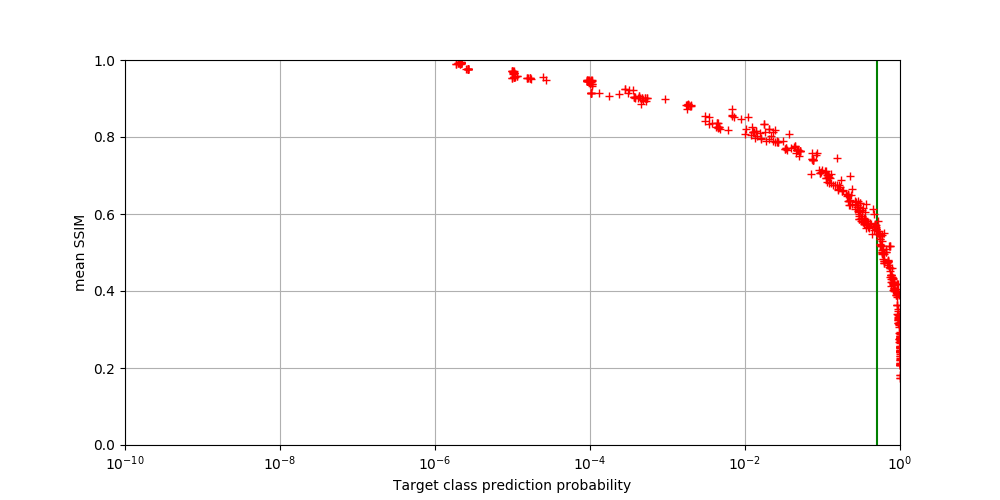

In [16]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10,5))
# fig.tight_layout()

ax.set_xlim(0.0000000001, 1)
ax.set_xlabel('Target class prediction probability')
ax.set_ylim(0, 1)
ax.set_ylabel('mean SSIM')
ax.set_xscale('log')
ax.grid(axis='both')
ax.vlines(0.5, -1, 1, colors='g')

callbacks = [MultiObjectiveReport(ax), GAStatus(fig)] # TODO BestImgReport(ax[1], best_picker=lambda fit: np.argmax(np.sum(fit, axis=-1)))]

- uniform vs std **norm** distributions??
- ga.run continue easily
- proper mechanism and standardized format for ga run result storing
- callback for intermediate individual checking
- persisting ga and run
- ssim border sensitivity??
- noise of different size than image, interpolation

- TODO link to SSIM

In [19]:
ga = GeneticAlgorithm(
#     initializer=PrePopulationInit(first_run[0].individuals),
    initializer=MultiSigmaRandomNormalInit((28, 28), (np.exp(np.linspace(0.5, 5, 100)) - 1) / (np.exp(5) - 1)),
    operator_graph=graph,
    objective_fnc=Images2LabelObjectiveFnc(model, target_class, images, sample_size=64, sample_ttl = 0.98),
    callbacks=callbacks,
    results_dir='playground/ga_runs'
)

In [20]:
%time final_pop, fitnesses, objectives = ga.run(population_size=512, generation_cap=32)

CPU times: user 23.6 s, sys: 8.92 s, total: 32.5 s
Wall time: 31.2 s


In [ ]:
%time result = ga.resume(64)

In [ ]:
first_run = final_pop, fitnesses, objectives

In [ ]:
prediction_bound = 0.5
ssim_bound = 0.7

filtered_indices, *_ = np.where(np.logical_and(final_pop.objectives[:, 0] > prediction_bound, final_pop.objectives[:, 1] > ssim_bound))
filtered_individuals = final_pop.individuals[filtered_indices]
filtered_objectives = final_pop.objectives[filtered_indices]

In [ ]:
test_data = test.X[test.y == source_class]
test_individuals = filtered_individuals

augmented_images = test_data + np.expand_dims(test_individuals, 1)
np.clip(augmented_images, 0, 1, out=augmented_images)
augmented_images_batch_shaped = augmented_images.reshape(-1, *augmented_images.shape[2:4], 1)

generalization = model(augmented_images_batch_shaped)[:, target_class].reshape(augmented_images.shape[:2])

In [ ]:
generalization.mean(), np.sum(generalization > 0.5), generalization.size

In [ ]:
generalization[84]

In [ ]:
filtered_indices[np.argsort(filtered_objectives[:,1])]

In [ ]:
%matplotlib notebook

individual_i = 212
image_i = 0

compare_fig, compare_ax = plt.subplots(1, 3, figsize=(13, 6))
compare_ax[0].imshow(test_data[image_i], cmap='gray', vmin=0, vmax=1)
compare_ax[1].imshow(final_pop.individuals[individual_i], cmap='plasma', vmin=-1, vmax=1)
compare_ax[2].imshow(test_data[image_i] + final_pop.individuals[individual_i], cmap='gray', vmin=0, vmax=1)